In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from datetime import datetime

%matplotlib inline

## Question: is death rate and recovery rate stable over time? difference between countries?

### 1. Read data

In [272]:
df_confirmed = pd.read_csv('novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
df_death = pd.read_csv('novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv')
df_recovered = pd.read_csv('novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv')

In [96]:
profile = ProfileReport(df_confirmed, title="Pandas Profiling Report")

In [186]:
profile.to_widgets()

## 2. Create tidy dataframes

In [273]:
df_confirmed['Province/State'].fillna(' ', inplace=True)
df_death['Province/State'].fillna(' ', inplace=True)
df_recovered['Province/State'].fillna(' ', inplace=True)

In [274]:
df_confirmed.set_index(['Province/State', 'Country/Region'], inplace=True)
df_death.set_index(['Province/State', 'Country/Region'], inplace=True)
df_recovered.set_index(['Province/State', 'Country/Region'], inplace=True)

In [275]:
# drop latitude and longitude since I'm not going to do visualization
df_confirmed.drop(labels=['Lat','Long'], inplace=True, axis=1)

df_confirmed.head()

,,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20
Province/State,Country/Region,,,,,,,,,,,,,,,,,,,,,
Anhui,Mainland China,1,9,15,39,60,70,106,152,200,237,...,860,889,910,934,950,962,973,982,986,987
Beijing,Mainland China,14,22,36,41,68,80,91,111,114,139,...,342,352,366,372,375,380,381,387,393,395
Chongqing,Mainland China,6,9,27,57,75,110,132,147,182,211,...,505,518,529,537,544,551,553,555,560,567
Fujian,Mainland China,1,5,10,18,35,59,80,84,101,120,...,267,272,279,281,285,287,290,292,293,293
Gansu,Mainland China,0,2,2,4,7,14,19,24,26,29,...,86,87,90,90,90,90,91,91,91,91


In [199]:
# calculate death rate and recovery rate using reported numbers

date_cols = df_confirmed.columns
df_death_rate = np.divide(df_death[date_cols], df_confirmed[date_cols]).fillna(method='ffill')
df_recovery_rate = np.divide(df_recovered[date_cols], df_confirmed[date_cols]).fillna(method='ffill')

df_remaining = df_confirmed - df_death - df_recovered

Initial inspection of raw data indicate some regions have super high death rate, I'm suspecting it's due to a small number of confirmed cases, hence high variance.

In [200]:
high_death_rate = df_death_rate.index[df_death_rate.max(axis=1) > 0.2]
high_death_rate

MultiIndex([(       'Hebei', 'Mainland China'),
            ('Heilongjiang', 'Mainland China'),
            (           ' ',    'Philippines'),
            (           ' ',           'Iran')],
           names=['Province/State', 'Country/Region'])

In [201]:
df_confirmed.loc[high_death_rate]

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Province/State Country/Region                                                
Hebei          Mainland China        1        1        2        8       13   
Heilongjiang   Mainland China        0        2        4        9       15   
               Philippines           0        0        0        0        0   
               Iran                  0        0        0        0        0   

                               1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
Province/State Country/Region                                                
Hebei          Mainland China       18       33       48       65       82   
Heilongjiang   Mainland China       21       33       38       44       59   
               Philippines           0        0        0        1        1   
               Iran                  0        0        0        0        0   

                               ...  2/11/20  2/12/20  2/13/20  2/14/20  \
Province/State Country/Region  ...                                       
Hebei          Mainland China  ...      239      251      265      283   
Heilongjiang   Mainland China  ...      360      378      395      419   
               Philippines     ...        3        3        3        3   
               Iran            ...        0        0        0        0   

                               2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  \
Province/State Country/Region                                                
Hebei          Mainland China      291      300      301      306      306   
Heilongjiang   Mainland China      425      445      457      464      470   
               Philippines           3        3        3        3        3   
               Iran                  0        0        0        0        2   

                               2/20/20  
Province/State Country/Region           
Hebei          Mainland China      307  
Heilongjiang   Mainland China      476  
               Philippines           3  
               Iran                  5  

[4 rows x 30 columns]

Data above confirmed the speculation that high death rate is due to small sample. We can add a filter to control for sample size.

The number will only be plotted when there is more than 10 confirmed cases.

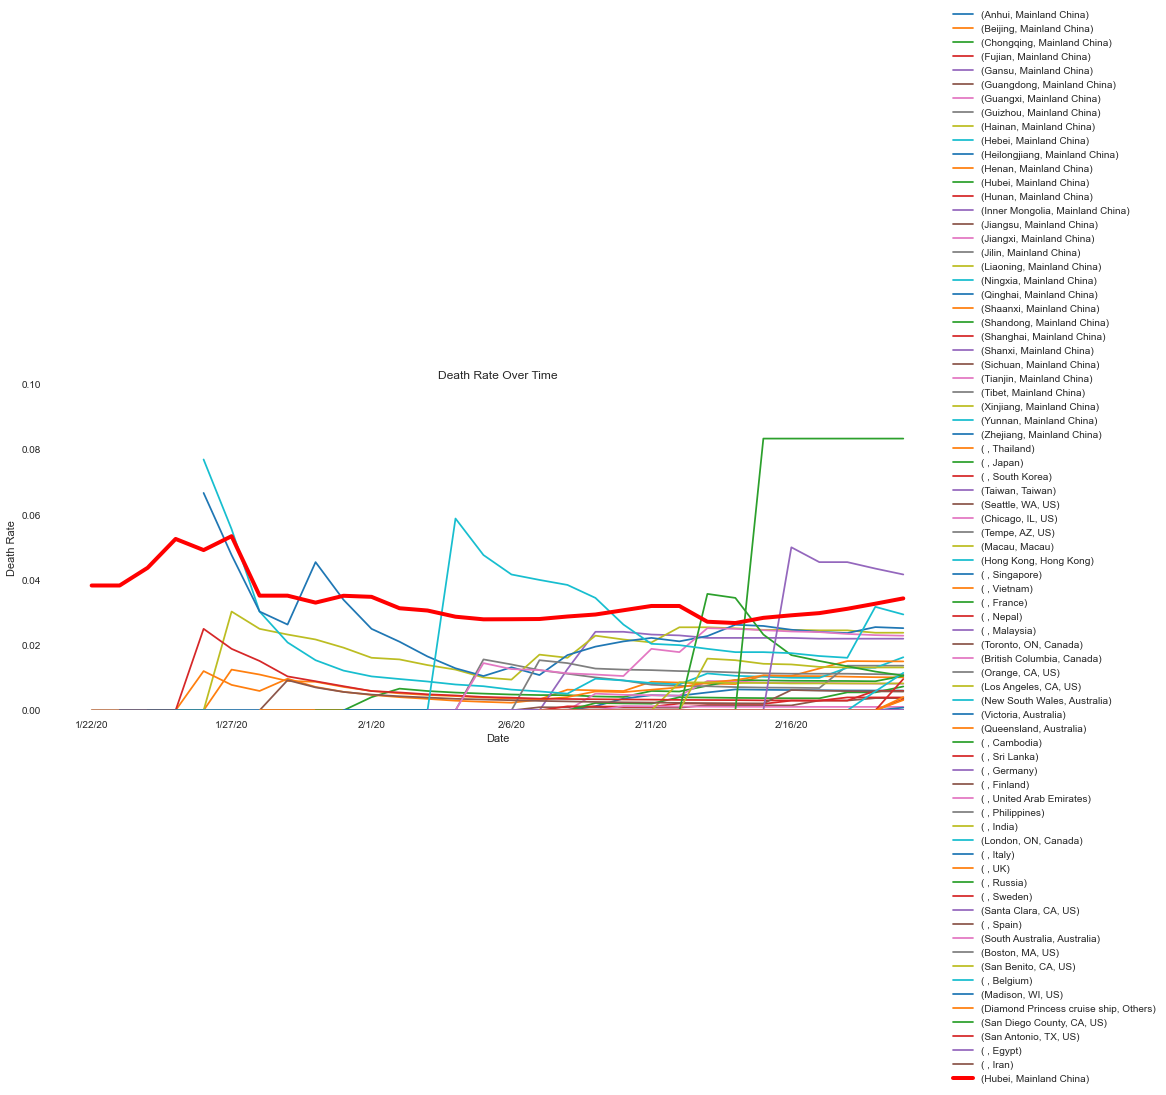

In [329]:
# plot death rate
fig, ax = plt.subplots(figsize=(16,6))
df_death_rate[df_confirmed > 10].T.plot(ax=ax, ylim=(0, 0.1), title='Death Rate Over Time')
df_death_rate.loc['Hubei','Mainland China'].plot(ax=ax, ylim=(0, 0.1), lw=4, color='r')
plt.xlabel('Date')
plt.ylabel('Death Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  

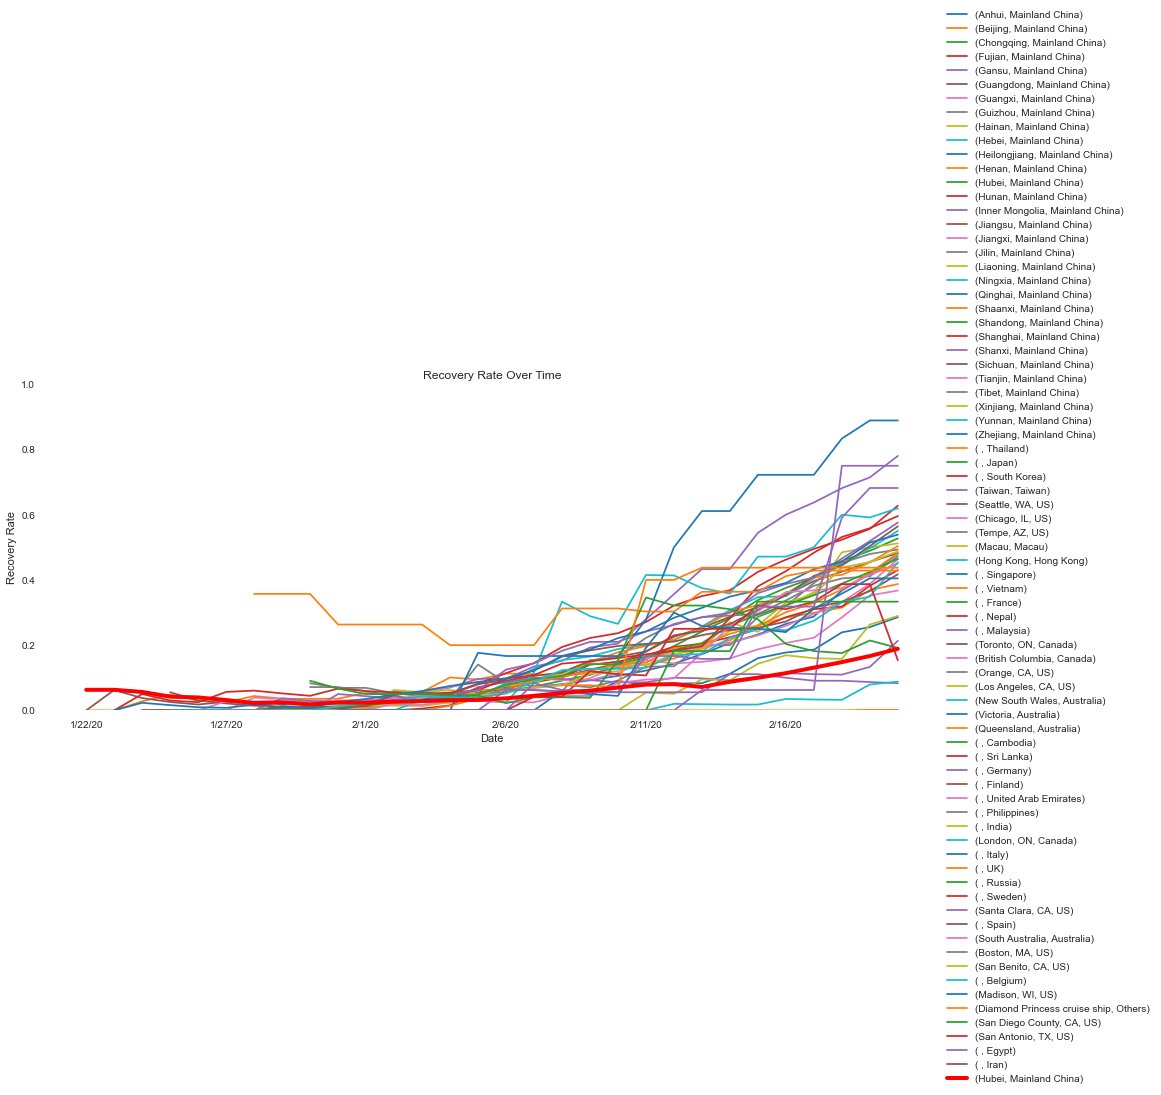

In [328]:
# plot recovery rate
fig, ax = plt.subplots(figsize=(16,6))
df_recovery_rate[df_confirmed > 10].T.plot(ax=ax, ylim=(0, 1), title='Recovery Rate Over Time')
df_recovery_rate.loc['Hubei','Mainland China'].plot(ax=ax, ylim=(0, 1), lw=4, color='r')
plt.xlabel('Date')
plt.ylabel('Recovery Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  

From figures above we can see Hubei's death rate is relatively stable around 3%, while recovery rate first dropped in late January and slowly increased early Febuary.

## 3. Align outbreak onset
As COVID-19 is spreading to different regions at different time, it might be a better view to align different regions by days since infection. Here I define the day when a region has more than 5 confirmed cases as Day 0 of infection, and create relative `Day since Infection` to plot by.

In [300]:
# helper functions for data preprocessing

def convert_to_ts(df):
    copy = df.copy()
    copy.index = [' '.join(idx) for idx in copy.index.values]
    ts = copy.T
    ts.index = pd.to_datetime(ts.index)
    return ts

# create new time series with aligned day 0
def get_outbreak_start(ts, min_threshold=5):
    sub_ts = ts[ts >= min_threshold]
    if len(sub_ts) < 1:
        return None, None
    else:
        day0 = sub_ts.index[0]
        sub_ts.index = (sub_ts.index - pd.to_datetime(day0)).days
        return sub_ts, day0
    
def align_day0(ts, min_threshold=5):
    sub_ts_list = []
    day0_dict = {}
    for col in ts.columns:
        sub_ts, day0 = get_outbreak_start(ts[col], min_threshold)
        sub_ts_list.append(sub_ts)
        day0_dict[col] = day0
    return pd.concat(sub_ts_list, axis=1), day0_dict

In [330]:
ts = convert_to_ts(df_confirmed)
ts_confirmed, day0_dict = align_day0(ts, min_threshold=10)

Text(0, 0.5, 'Number of confirmed cases - Hubei Province')

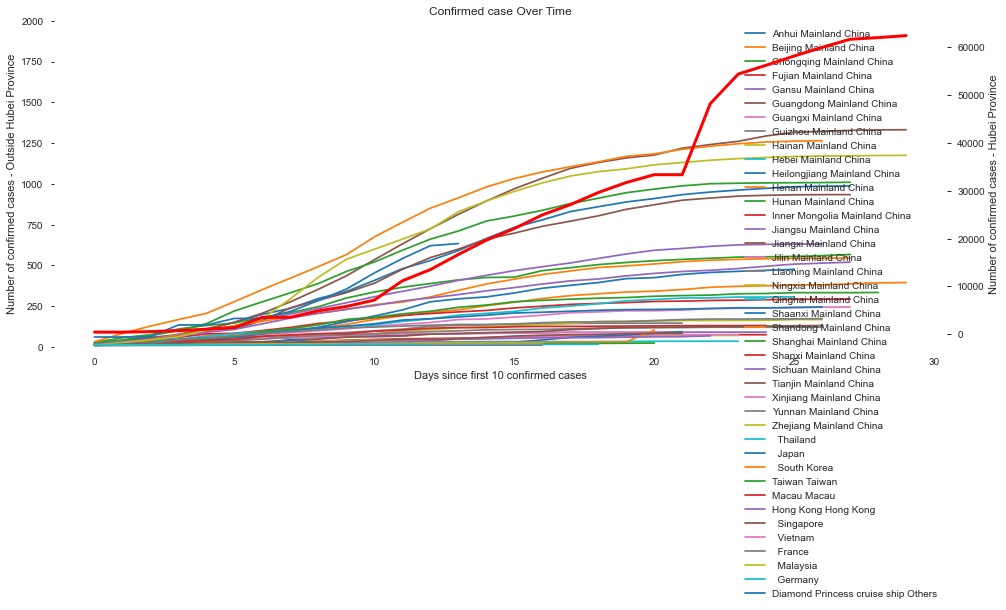

In [332]:
# plot aligned # of cases
fig, ax = plt.subplots(figsize=(16,6))
ts_confirmed.drop('Hubei Mainland China', axis=1).plot(ax=ax, ylim=(0, 2000), title='Confirmed case Over Time')
plt.xlabel('Days since first 10 confirmed cases')
plt.ylabel('Number of confirmed cases - Outside Hubei Province')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
# plot Hubei on a secondary axis as it has a much bigger scale than other regions
ts_confirmed['Hubei Mainland China'].plot(ax=ax, secondary_y=True, lw=3, color='r')
ax.right_ax.set_ylabel('Number of confirmed cases - Hubei Province')

In [348]:
ts_confirmed.max().nlargest(5)

Hubei Mainland China        62442.0
Guangdong Mainland China     1332.0
Henan Mainland China         1265.0
Zhejiang Mainland China      1175.0
Hunan Mainland China         1010.0
dtype: float64

## 4. View for death rate and recovery rate after alignment

In [306]:
ts_d = convert_to_ts(df_death.drop(labels=['Lat','Long'],axis=1))
ts_r = convert_to_ts(df_recovered.drop(labels=['Lat','Long'],axis=1))

In [293]:
ts_death = align_day0(ts_d, min_threshold=0)
ts_recovered = align_day0(ts_r, min_threshold=0)

In [308]:
def align_day0_with_dict(ts, day0_dict, min_threshold=0):
    ts = ts.copy()
    sub_ts_list = []
    
    for col in ts.columns:
        try:
            ts[col].index = (ts[col].index - pd.to_datetime(day0_dict[col])).days
            sub_ts_list.append(ts[col])
        except:
            continue
    return pd.concat(sub_ts_list, axis=1)


In [333]:
ts_death = align_day0_with_dict(ts_d, day0_dict, min_threshold=0).loc[0:]
ts_recovered = align_day0_with_dict(ts_r, day0_dict, min_threshold=0).loc[0:]

In [334]:
ts_death_rate = np.divide(ts_death, ts_confirmed)
ts_recovered_rate = np.divide(ts_recovered, ts_confirmed)

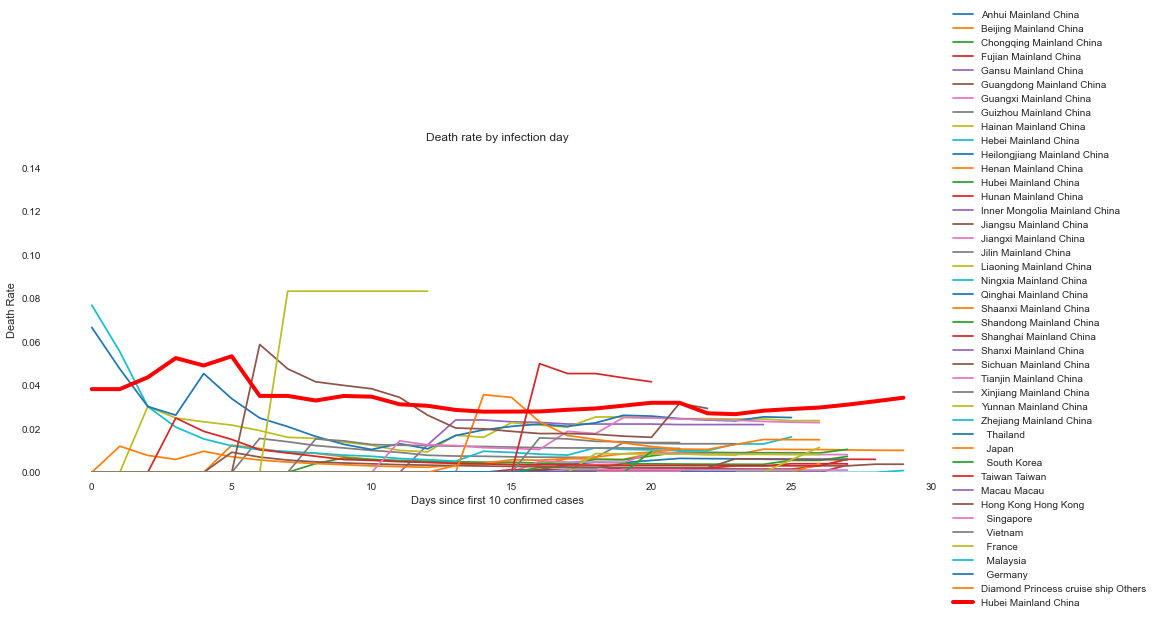

In [335]:
fig, ax = plt.subplots(figsize=(16,6))
ts_death_rate.plot(ax=ax, ylim=(0, 0.15), title='Death rate by infection day')
ts_death_rate['Hubei Mainland China'].plot(ax=ax, ylim=(0, 0.15), lw=4, color='r')
plt.xlabel('Days since first 10 confirmed cases')
plt.ylabel('Death Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  

In [340]:
ts_death_rate.max().nlargest(5)

  France                       0.083333
Hebei Mainland China           0.076923
Heilongjiang Mainland China    0.066667
Hong Kong Hong Kong            0.058824
Hubei Mainland China           0.053408
dtype: float64

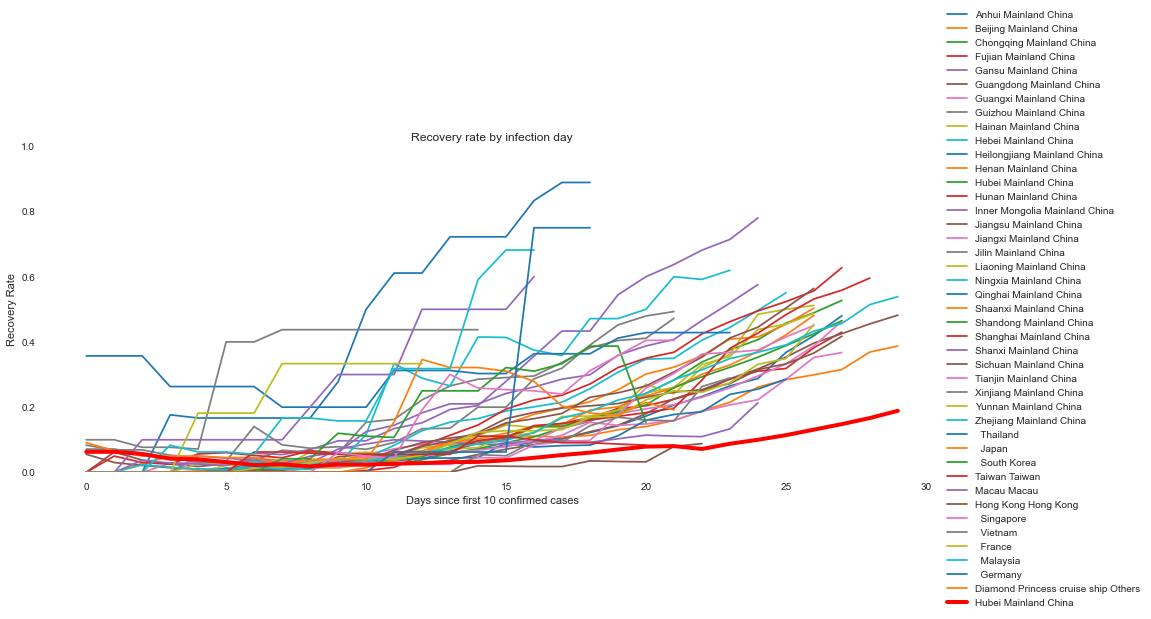

In [336]:
fig, ax = plt.subplots(figsize=(16,6))
ts_recovered_rate.plot(ax=ax, ylim=(0, 1), title='Recovery rate by infection day')
ts_recovered_rate['Hubei Mainland China'].plot(ax=ax, ylim=(0, 1), lw=4, color='r')
plt.xlabel('Days since first 10 confirmed cases')
plt.ylabel('Recovery Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  

In [338]:
ts_recovered_rate.max().nlargest(5)

Qinghai Mainland China    0.888889
Gansu Mainland China      0.780220
  Germany                 0.750000
  Malaysia                0.681818
Hunan Mainland China      0.627723
dtype: float64

Generally, we can see a slight decreasing trend in death rate and increasing trend in recovery rate in most regions. Hubei province has slightly higher death rate and lower recovery rate compared to other regions. This is potentially due to the outbreak overwhelming the hospitals and medical facilities. For other regions, death rate stablized after roughly 10 days since first reported death.

Precautions have been taken in otehr regions in China, as well as rest of the world. With better preparation and strict policy on quarantine, rest of China is doing no worse than other regions in the world. Due to the difference in onset, we will need more data over time to conduct a more accurate comparison.